# **Uniaxial Extension Experiment**

In [1]:
import pymecht as pmt
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The pymecht.UniaxialExtension module can calculate deformation given a force, or force given a deformation, under different material conditions. For details about the material options, please refer to the [MatModel module](https://pymecht.readthedocs.io/en/examples/matmodel.html). The default settings for displacement and force are `stretch` and `force` respectively. For details about the description of different options in displacement or force, please refer to the [pymecht.SampleExperiment.UniaxialExtension](https://pymecht.readthedocs.io/en/examples/sampleexperiment.html#pymecht.SampleExperiment.UniaxialExtension).

## 1. Given deformation, calculating stress or force

Firstly, we begin by calculating the force given a deformation. The `pymecht.UniaxialExtension` module offers four displacement measurement options: stretch, strain, length, and deltal. The default setting is `disp_measure = 'stretch'`. You can change the displacement measurement setting using the `disp_measure` option. The first example is given `length` to calculate `force`.

<a name="section1.1"></a>
### 1.1 Given deformation by `disp_measure = length`

The whole process of simulation uniaxial experiment can be divided into 5 steps: 
1. Define material 
2. Set sample and measurement option 
3. Set parameter values 
4. Give measurements value (force or displacement) 
5. Calculation

In this example, the material properties are defined as a combination of the Neo-Hookean model and the Gasser-Ogden-Holzapfel model. The displacement measurement option is set to `disp_measure = 'length'`, and the force measurement remains at the default `force_measure = 'force'`. For the uniaxial extension simulation, the fibre direction is set to `[1, 0, 0]`.

In [3]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample and measurement option
sample = pmt.UniaxialExtension(mat, disp_measure = 'length')
pmt.specify_single_fiber(sample)

#set parameter values
sample_params = sample.parameters
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',1)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)
print(sample)
print(sample_params)

Fiber directions set to  0  degrees ( 0.0  radians)
An object of type UniaxialExtensionwith length as input, force as output, and the following material
Material model with 2 components:
Component1: NH with fiber direction(s):[array([1., 0., 0.])]
Component2: GOH with fiber direction(s):[array([1., 0., 0.])]

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                1.00        No          1.00e-04    1.00e+03    
A0                1.00        No          1.00e-04    1.00e+03    
mu_0              1.00        No          1.00e-04    1.00e+02    
k1_1              10.00       No          0.10        30.00       
k2_1              10.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33        
------------------------------------------------------------------



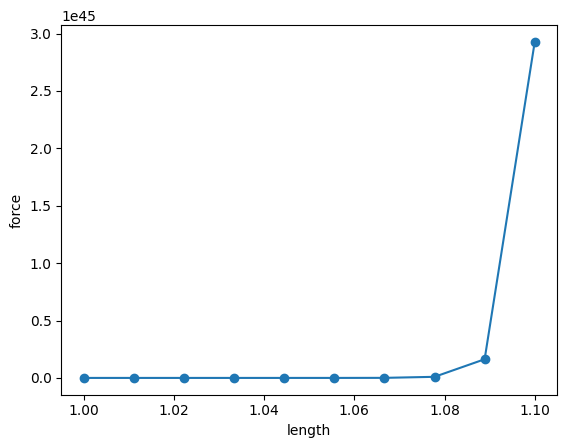

In [17]:
#give applied displacement
applied_length = np.linspace(1,1.1,10)

#calculating force
force = sample.disp_controlled(applied_length,sample_params)

#post-processing
plt.plot(applied_length,force,'-o')
plt.ylabel('force')
plt.xlabel('length')
plt.show()

### 1.2 Other types of deformation option (`'stretch', 'strain'` and `'deltal'`)

It also offers other displacement measurement options. Following the steps outlined above, examples of these alternative options are provided below. To simplify the code, the displacement values are generated and stored in `label_disp`, which is a dictionary. These values are then used in a loop. The force measurement remains at the default setting.

Fiber directions set to  0  degrees ( 0.0  radians)


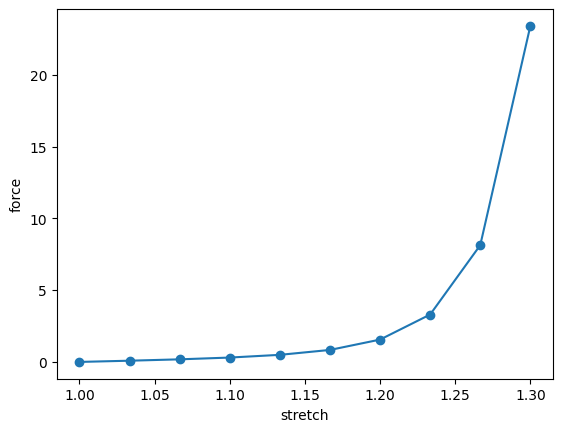

Fiber directions set to  0  degrees ( 0.0  radians)


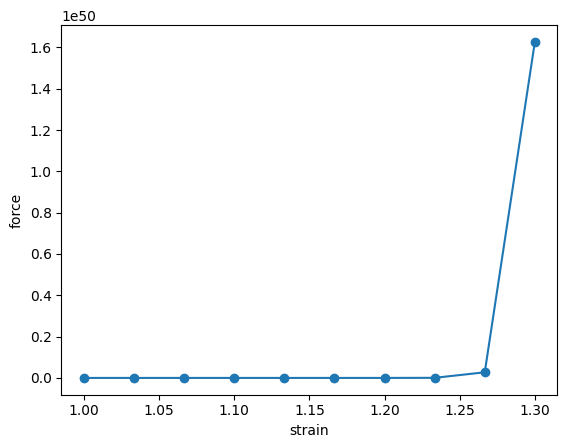

Fiber directions set to  0  degrees ( 0.0  radians)


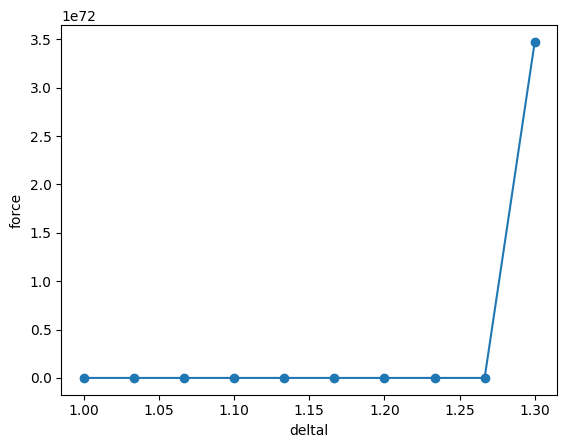

In [18]:
#define material
mat = pmt.MatModel('nh', 'goh')


label_disp = {'stretch': np.linspace(1,1.3,10), 'strain': np.linspace(1,1.3,10),'deltal': np.linspace(1,1.3,10)} #the different types of disp measurements


for key, value in label_disp.items():
    
    #set sample and measurement option
    sample = pmt.UniaxialExtension(mat, disp_measure = key )
    
    #set parameter value
    sample_params = sample.parameters
    pmt.specify_single_fiber(sample)
    sample_params.set('mu_0',5)
    sample_params.set('A0',0.1)
    sample_params.set('L0',1)
    sample_params.set('k1_1',5)
    sample_params.set('k2_1',15)
    sample_params.set('k3_1',0.1)
    
    #given applied displacement
    applied_disp = value #applied displacement
    
    #calculating force
    force = sample.disp_controlled(applied_disp, sample_params)
    
    #post-processing
    plt.plot(applied_disp,force,'-o')
    plt.ylabel('force')
    plt.xlabel(key)
    plt.show()

## 2. Given force, calculating deromation

Similar to the displacement measurement options, the force measurement in `pymechT` also offers several alternatives. The available options for force measurement are: `force (default), cauchy, 1pk,` and `2pk`. You can change the force measurement setting using the `force_measure` option. The example gives the default option (force) firstly, and the displacement measurment is `stretch`. The process is same as the steps which we have shown in [Section 1.1](#section1.1).

## 2.1 Given force by `'force_measure = force'`

In [36]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample
sample = pmt.UniaxialExtension(mat, force_measure = 'force' )
pmt.specify_single_fiber(sample)

#set parameter value
sample_params = sample.parameters
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',10)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)
print(sample)
print(sample_params)

Fiber directions set to  0  degrees ( 0.0  radians)
An object of type UniaxialExtensionwith stretch as input, force as output, and the following material
Material model with 2 components:
Component1: NH with fiber direction(s):[array([1., 0., 0.])]
Component2: GOH with fiber direction(s):[array([1., 0., 0.])]

------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L0                10.00       No          1.00e-04    1.00e+03    
A0                0.10        No          1.00e-04    1.00e+03    
mu_0              5.00        No          1.00e-04    1.00e+02    
k1_1              5.00        No          0.10        30.00       
k2_1              15.00       No          0.10        30.00       
k3_1              0.10        No          0.00        0.33        
------------------------------------------------------------------



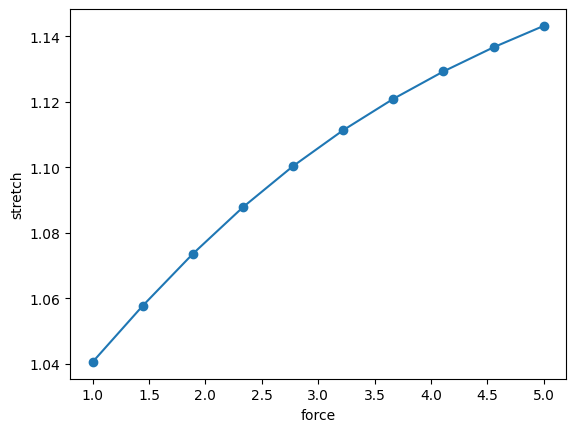

In [31]:
#apply force
applied_force = np.linspace(1,5,10)

#calculating deformation
deformation = sample.force_controlled(applied_force, sample_params)

#post-processing
plt.plot(applied_force,deformation,'-o')
plt.ylabel('stretch')
plt.xlabel('force')
plt.show()

## 2.1 Other types of force option (`'cauchy' , '1pk'` and `'2pk'`)

The other alternative options in force measurement are shown below.

Fiber directions set to  0  degrees ( 0.0  radians)


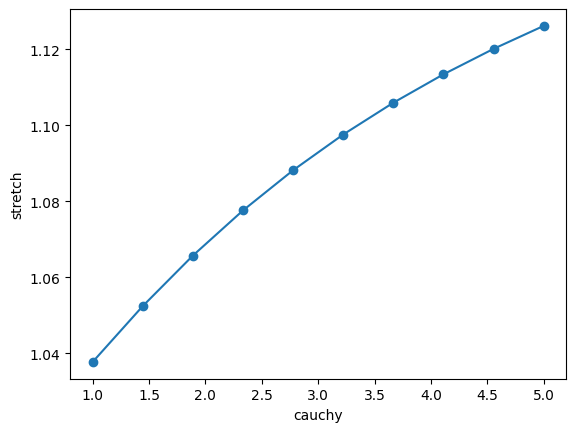

Fiber directions set to  0  degrees ( 0.0  radians)


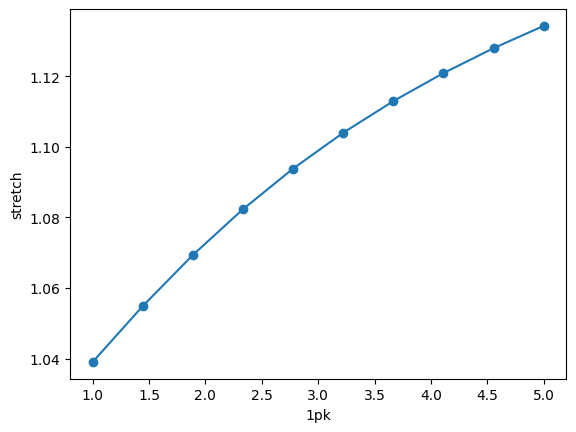

Fiber directions set to  0  degrees ( 0.0  radians)


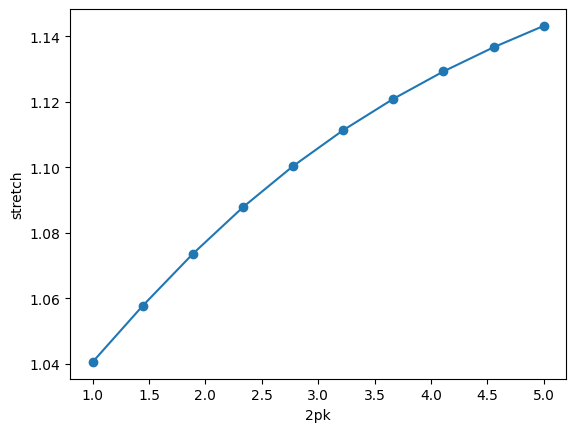

In [29]:
#define material
mat = pmt.MatModel('nh', 'goh')

label_force = {'cauchy': np.linspace(1,5,10), '1pk': np.linspace(1,5,10),'2pk': np.linspace(1,5,10)} #different types of force measurements used in for loop

for key, value in label_force.items():
    sample = pmt.UniaxialExtension(mat, force_measure = key )   
    
    #parameter setting
    sample_params = sample.parameters
    pmt.specify_single_fiber(sample)
    sample_params.set('mu_0',5)
    sample_params.set('A0',0.1)
    sample_params.set('L0',1)
    sample_params.set('k1_1',5)
    sample_params.set('k2_1',15)
    sample_params.set('k3_1',0.1)
    
    #force setting
    applied_force = value
    
    #calculating deformation (strech)
    disp = sample.force_controlled(applied_force, sample_params)
    
    #post-process
    plt.plot(applied_force,disp,'-o')
    plt.ylabel('stretch')
    plt.xlabel(key)
    plt.show()

## 3. The free choice of different `'disp_measure'` and `'force_measure'`

You can also freely combine different options for `disp_measure` and `force_measure`. For example, we used `disp_measure = 'strain'` and `force_measure = 'cauchy'`.

Fiber directions set to  0  degrees ( 0.0  radians)


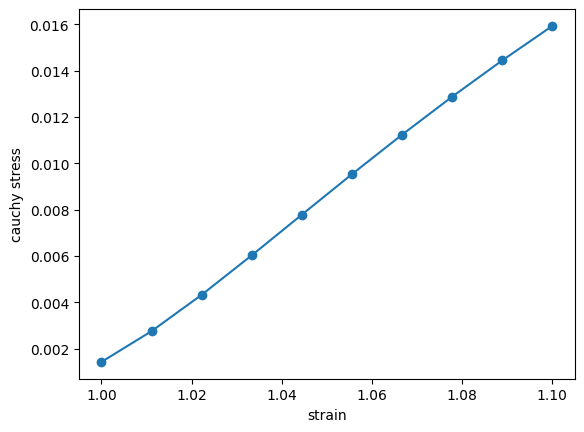

In [32]:
#define material
mat = pmt.MatModel('nh', 'goh')

#set sample
sample = pmt.UniaxialExtension(mat, disp_measure = 'strain ', force_measure = 'cauchy' )
sample_params = sample.parameters
pmt.specify_single_fiber(sample)

#set parameter
sample_params.set('mu_0',5)
sample_params.set('A0',0.1)
sample_params.set('L0',10)
sample_params.set('k1_1',5)
sample_params.set('k2_1',15)
sample_params.set('k3_1',0.1)

#calculating displacement (force)
applied_strain = np.linspace(1,1.1,10)

#calculating force (displacement)
cauchy = sample.force_controlled(applied_force, sample_params)

#post-process
plt.plot(applied_strain,cauchy,'-o')
plt.ylabel('cauchy stress')
plt.xlabel('strain')
plt.show()